In [4]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [5]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


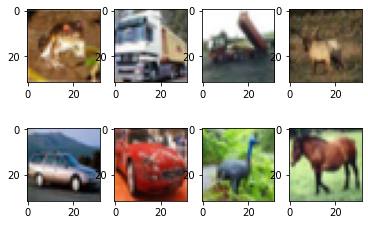

In [6]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [22]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [23]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [24]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [31]:
!pip3 install tensorflow

     |████████████████████████████████| 217.5 MB 75 kB/s s eta 0:00:01
     |████████████████████████████████| 13.0 MB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.1 MB/s  eta 0:00:01
     |████████████████████████████████| 4.3 MB 58.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 48.5 MB/s eta 0:00:01
     |███████████████████████████████▉| 1.4 MB 15.1 MB/s eta 0:00:01     |████████████████████████████████| 1.4 MB 15.1 MB/s 
     |████████████████████████████████| 961 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 15

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import time
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [112]:
def split_data(images, labels, t_size, v_size):
    # cross-validation (create training and test data for the model)
    img_train_all, img_test, label_train_number_all, label_test_number = train_test_split(imgs, labels, test_size = t_size, random_state=42)
    # create training and validation data for the model
    img_train, img_val, label_train_number, label_val_number  = train_test_split(img_train_all, label_train_number_all, test_size=v_size, random_state=1)
    
    label_train_all = np.eye(10)[label_train_number_all]
    label_train = np.eye(10)[label_train_number]
    label_test = np.eye(10)[label_test_number]
    label_val = np.eye(10)[label_val_number]
    
    img_train_all = tf.cast(img_train_all, dtype='float32')/255.0
    img_train = tf.cast(img_train, dtype='float32')/255.0
    img_val = tf.cast(img_val, dtype='float32')/255.0
    #img_test = tf.cast(img_test, dtype='float32')/255.0
    
    train_dataGen = ImageDataGenerator(
        featurewise_center=True, # set the mean of the inputs to 0 over the dataset
        featurewise_std_normalization=True, # divide the inputs by standard deviation of the dataset
        rotation_range=10, # degree range for random rotations
        width_shift_range=0.1, # the fraction of total width
        height_shift_range=0.1, # the fraction of total height
        horizontal_flip=True) # flip the inputs horizontally randomly

    train_dataGen.fit(img_train)
    train_dataGen.fit(img_train_all)

    test_dataGen = ImageDataGenerator(
        featurewise_center=True, # set the mean of the inputs to 0 over the dataset
        featurewise_std_normalization=True) # divide the inputs by standard deviation of the dataset

    test_dataGen.fit(img_val)
    #test_dataGen.fit(img_test)
    
    return img_train_all, img_train, img_val, img_test, label_train_all, label_train, label_test, label_test_number, label_val
    

In [99]:
img_train_all, img_train, img_val, img_test, label_train_all, label_train, label_test, label_test_number, label_val = split_data(imgs, noisy_labels, 0.1, 0.2)

In [31]:
# to be deleted

# cross-validation (create training and test data for the model)
img_train_all, img_test, label_train_number_all, label_test_number = train_test_split(imgs, noisy_labels, test_size = 0.1, random_state=42)
# create training an dvalidation data for the model
img_train, img_val, label_train_number, label_val_number  = train_test_split(img_train_all, label_train_number_all, test_size=0.2, random_state=1)

In [32]:
# to be deleted

label_train_all = np.eye(10)[label_train_number_all]
label_train = np.eye(10)[label_train_number]
label_test = np.eye(10)[label_test_number]
label_val = np.eye(10)[label_val_number]

In [33]:
# to be deleted

img_train_all = tf.cast(img_train_all, dtype='float32')/255.0
img_train = tf.cast(img_train, dtype='float32')/255.0
img_val = tf.cast(img_val, dtype='float32')/255.0
#img_test = tf.cast(img_test, dtype='float32')/255.0

In [34]:
# to be deleted

train_dataGen = ImageDataGenerator(
    featurewise_center=True, # set the mean of the inputs to 0 over the dataset
    featurewise_std_normalization=True, # divide the inputs by standard deviation of the dataset
    rotation_range=10, # degree range for random rotations
    width_shift_range=0.1, # the fraction of total width
    height_shift_range=0.1, # the fraction of total height
    horizontal_flip=True) # flip the inputs horizontally randomly

train_dataGen.fit(img_train)
train_dataGen.fit(img_train_all)

test_dataGen = ImageDataGenerator(
    featurewise_center=True, # set the mean of the inputs to 0 over the dataset
    featurewise_std_normalization=True) # divide the inputs by standard deviation of the dataset

test_dataGen.fit(img_val)
#test_dataGen.fit(img_test)

In [101]:
# parameters: the number of conv2D and the droput rate of the final dropout layer

def define_modelI(final_dropout_rate=0.25, number_of_conv2D=2):
    start_time = time.time()
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same', activation ='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    for i in range(number_of_conv2D-1):
        model.add(Conv2D(32*(2**(i+1)),(3,3),padding='same', activation ='relu'))
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32*(2^number_of_conv2D), activation = 'relu'))
    model.add(Dropout(final_dropout_rate))
    model.add(Dense(10, activation = 'softmax'))
    return model

In [102]:
# train the model on training data and evaluate on validation data

def train_modelI(model, number_of_epochs=15):
    start_time = time.time()
    model.compile(optimizer= tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy']
              )
    model.fit(img_train, label_train, batch_size= 64, epochs=number_of_epochs,
              validation_data=(img_val, label_val), verbose=0
             )
    print(f" Model took {time.time() - start_time} seconds to train.")
    return model

In [202]:
# use cross-validation to evaluate CNN models with different hyperparameters trained on multiple number of epochs

epochs_list = [10, 15, 20]
dropout_rate_list = [0.2, 0.25, 0.3]
number_of_conv2D_list = [2, 3, 4]

for number_of_epochs in epochs_list:
    for dropout_rate in dropout_rate_list:
        for number_of_conv2D in number_of_conv2D_list:
            print(f''' --- # of conv2D: {number_of_conv2D}, # of epochs: {number_of_epochs}, final dropout rate: {dropout_rate}''')
            modelI = define_modelI(dropout_rate, number_of_conv2D)
            trained_modelI = train_modelI(modelI, number_of_epochs)
            eval_model = trained_modelI.evaluate(img_val,label_val)
            print(f'''Loss: {eval_model[0]},  Accuracy: {eval_model[1]}''')

 --- # of conv2D: 2, # of epochs: 10, final dropout rate: 0.2
 Model took 228.65734696388245 seconds to train.
282/282 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0947
Loss: 2.30258846282959,  Accuracy: 0.09466666728258133
 --- # of conv2D: 3, # of epochs: 10, final dropout rate: 0.2
 Model took 363.359925031662 seconds to train.
282/282 [==============================] - 2s 5ms/step - loss: 2.3024 - accuracy: 0.0989
Loss: 2.3024299144744873,  Accuracy: 0.09888888895511627
 --- # of conv2D: 4, # of epochs: 10, final dropout rate: 0.2
 Model took 447.9237492084503 seconds to train.
282/282 [==============================] - 2s 8ms/step - loss: 2.1944 - accuracy: 0.2359
Loss: 2.1944169998168945,  Accuracy: 0.23588888347148895
 --- # of conv2D: 2, # of epochs: 10, final dropout rate: 0.25
 Model took 258.29135489463806 seconds to train.
282/282 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0947
Loss: 2.30258846282959,  Accuracy

We obeserve that we get the highest accuracy -0.2420- for the following hyperparameters:  
- number of conv2D --> 4  
- droput rate of the final Dropout layer --> 0.2  
- number of epochs the model was trained --> 20  

The model took 733.29 seconds or ~12 minutes to train.

Considering that we want to to have short training time we decided to use the following hyperparameters:
- number of conv2D --> 4  
- droput rate of the final Dropout layer --> 0.25  
- number of epochs the model was trained --> 15  
that give accuracy 0.2351.

This model took 585.32 seconds or ~9.7 minutes to train.

In [37]:
# add validation data to the final training data
img_train = img_train_all
label_train = label_train_all

In [48]:
# define and train (on train and validation data) final modelI
modelI = define_modelI(0.25, 4)
trained_modelI = train_modelI(modelI, 15)

 Model took 686.6723811626434 seconds to train.


In [49]:
# evaluate final modelI on test data
img_test_fit = tf.cast(img_test, dtype='float32')/255.0
test_dataGen.fit(img_test_fit)
eval_model = trained_modelI.evaluate(img_test_fit,label_test)
print(f'''Loss: {eval_model[0]},  Accuracy: {eval_model[1]}''')

157/157 [==============================] - 1s 6ms/step - loss: 2.1974 - accuracy: 0.2342
Loss: 2.1973745822906494,  Accuracy: 0.23420000076293945


In [54]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    image = tf.cast(image, dtype='float32')/255.0
    eval_dataGen = ImageDataGenerator(
        featurewise_center=True, # set the mean of the inputs to 0 over the dataset
        featurewise_std_normalization=True) # divide the inputs by standard deviation of the dataset

    eval_dataGen.fit(image)
    prediction = np.argmax(trained_modelI.predict(image))
    return prediction

### 2.3. Model II

Model II is exactly the same predictive model as Model I. However, we added some extra procedures to address the label noise issue. 

In [264]:
def train_modelII(model, number_of_epochs=15):
    start_time = time.time()
    model.compile(optimizer= tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy']
              )
    model.fit(img_train_II, label_train_II, batch_size= 64, epochs=number_of_epochs,
              validation_data=(img_val_II, label_val_II), verbose=0
             )
    print(f" Model took {time.time() - start_time} seconds to train.")
    return model

We will first clean the labels as follows:  
- we will train model_I on clean data  
- we will use model_I to clean the noisy labels (for every image we will predict the correct label)

In [291]:
# we will first divide the clean data to training and validation data to check the accuracy of model_I on clean data

clean_imgs=imgs[0:10000].reshape(-1, 32,32,3)
# cross-validation (create training and validation data for the model)
clean_img_train, clean_img_val, clean_label_train_number, clean_label_val_number = train_test_split(clean_imgs, clean_labels, test_size = 0.1, random_state=42)


In [292]:
clean_label_train = np.eye(10)[clean_label_train_number]
clean_label_val = np.eye(10)[clean_label_val_number]

clean_img_train = tf.cast(clean_img_train, dtype='float32')/255.0

train_dataGen = ImageDataGenerator(
    featurewise_center=True, # set the mean of the inputs to 0 over the dataset
    featurewise_std_normalization=True, # divide the inputs by standard deviation of the dataset
    rotation_range=10, # degree range for random rotations
    width_shift_range=0.1, # the fraction of total width
    height_shift_range=0.1, # the fraction of total height
    horizontal_flip=True) # flip the inputs horizontally randomly

train_dataGen.fit(clean_img_train)

test_dataGen = ImageDataGenerator(
    featurewise_center=True, # set the mean of the inputs to 0 over the dataset
    featurewise_std_normalization=True) # divide the inputs by standard deviation of the dataset

test_dataGen.fit(clean_img_val)

In [293]:
img_train_II = clean_img_train
label_train_II = clean_label_train
img_val_II = clean_img_val
label_val_II = clean_label_val

# train model_I on clean data
modelII = define_modelI(0.25, 4)
trained_modelII = train_modelII(modelII, 15)

 Model took 130.40013718605042 seconds to train.


In [294]:
# evaluate final modelI on clean test data
eval_model = trained_modelII.evaluate(img_val_II,label_val_II)
print(f'''Loss: {eval_model[0]},  Accuracy: {eval_model[1]}''')

32/32 [==============================] - 0s 5ms/step - loss: 152.4330 - accuracy: 0.5240
Loss: 152.43299865722656,  Accuracy: 0.5239999890327454


We observe that our model achieves accuracy of ~0.53 on predicting the correct labels having been trained on only 9,000 clean data.

### After training model on 9000 clean imgs we predict the label of the rest 1000 clean imgs and create a confusion matrix to see where you do best/worst

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [257]:
labels_pred = np.argmax(trained_modelII.predict(img_val_II), axis = 1)
cf_matrix = confusion_matrix(clean_label_val_number, labels_pred)

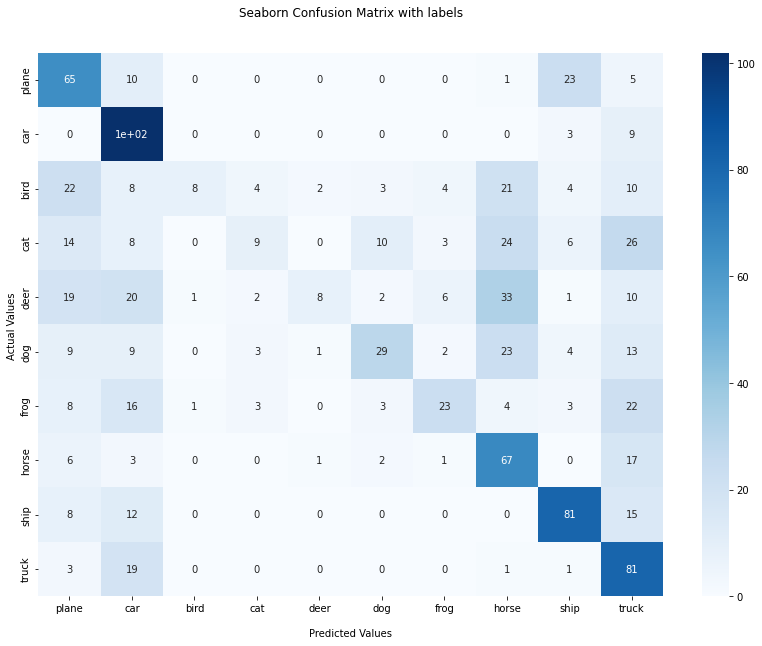

In [258]:
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

### Predict correct label of noisy images and create a confusion matrix to see where we do best/worst

In [296]:
# we will now correct the noisy labels

noisy_imgs = imgs[10000:].reshape(-1, 32,32,3)
noisy_imgs = tf.cast(noisy_imgs, dtype='float32')/255.0
test_dataGen.fit(noisy_imgs)

labels_pred = np.argmax(trained_modelII.predict(noisy_imgs), axis = 1)

In [297]:
labels_pred

array([0, 7, 6, ..., 9, 1, 1])

In [272]:
cleaned_labels = clean_labels
for i in range(len(noisy_imgs)):
    cleaned_labels = np.append(cleaned_labels, labels_pred[i])

In [180]:
from keras.datasets import cifar10

In [224]:
# read true labels of noisy data

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
noisy_clean_labels = []
for i in range(10000, 50000):
    noisy_clean_labels.append(y_train[i][0])

In [262]:
cf_matrix = confusion_matrix(noisy_clean_labels, labels_pred)

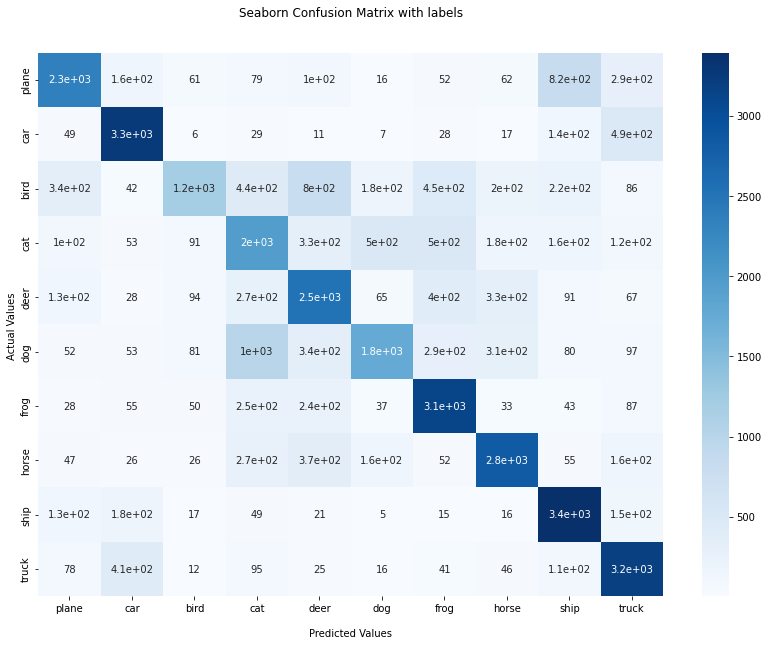

In [263]:
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

In [270]:
cleaned_labels[:100]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3,
       6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7,
       1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1,
       4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7,
       9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1])

We will now train our model.

In [298]:
img_train_all_II, img_train_II, img_val_II, img_test_II, label_train_all_II, label_train_II, label_test_II, label_test_number_II, label_val_II = split_data(imgs, cleaned_labels, 0.1, 0.2)

In [301]:
modelII = define_modelI(0.25, 4)
trained_modelII = train_modelII(modelII, 15)

 Model took 540.471028804779 seconds to train.


In [302]:
# evaluate final modelII on test data
img_test_fit_II = tf.cast(img_test_II, dtype='float32')/255.0
test_dataGen.fit(img_test_fit_II)
eval_model = trained_modelII.evaluate(img_test_fit_II,label_test_II)
print(f'''Loss: {eval_model[0]},  Accuracy: {eval_model[1]}''')

157/157 [==============================] - 1s 6ms/step - loss: 0.6437 - accuracy: 0.7636
Loss: 0.6437436938285828,  Accuracy: 0.7635999917984009


In [315]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    image = tf.cast(image, dtype='float32')/255.0
    eval_dataGen = ImageDataGenerator(
        featurewise_center=True, # set the mean of the inputs to 0 over the dataset
        featurewise_std_normalization=True) # divide the inputs by standard deviation of the dataset

    eval_dataGen.fit(image)
    prediction = np.argmax(trained_modelII.predict(image))
    return prediction

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [282]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

### Evaluate model_I on validation set (that does not necessarily include clean labels)

In [55]:
evaluation(model_I, label_test_number, img_test)

              precision    recall  f1-score   support

           0       0.29      0.21      0.24       470
           1       0.33      0.29      0.31       486
           2       0.21      0.09      0.13       514
           3       0.20      0.20      0.20       508
           4       0.17      0.32      0.23       500
           5       0.23      0.21      0.22       500
           6       0.19      0.37      0.25       504
           7       0.33      0.16      0.21       509
           8       0.31      0.26      0.29       529
           9       0.26      0.25      0.25       480

    accuracy                           0.23      5000
   macro avg       0.25      0.23      0.23      5000
weighted avg       0.25      0.23      0.23      5000



### Evaluate model_II on validation set (that includes corrected labels)

In [ ]:
evaluation(model_II, label_test_number_II, img_test_II)